# Semantic chunk data exploration

Now that we have the text data split into semantic chunks, let's load them up and take a quick look at what we have.

## Notebook setup

In [1]:
# Change working directory to parent so we can import as we would
# from the perplexity ratio score root directory
%cd ..

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Internal imports
import configuration as config

/home/siderealyear/projects/llm_detector/perplexity_ratio_score


## 1. Data loading

In [2]:
data_file=f'{config.INTERMEDIATE_DATA_PATH}/all_chunks.json'
data_df=pd.read_json(data_file)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24667559 entries, 0 to 24667558
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   synthetic  int64 
 2   author     object
 3   source     object
dtypes: int64(1), object(3)
memory usage: 752.8+ MB


In [3]:
data_df.head()

,text,synthetic,author,source
0,A powerful story about a culture clash and the...,0,human,grinberg
1,"Still, there's been plenty of speculation abou...",1,unknown_model,yatsenko
2,Bowen’s family system theory can be used to di...,0,human,grinberg
3,● Why? – The gene that controls the direction ...,0,human,yatsenko
4,be more safety for everyone.,0,human,gerami


## 2. Data composition

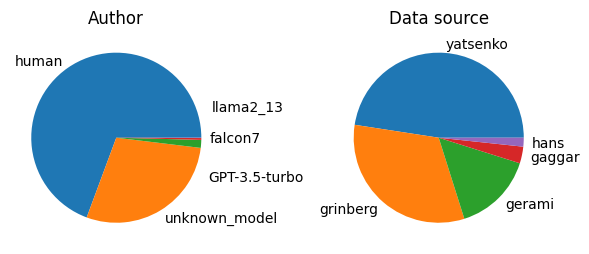

In [4]:
def fix_labels(mylabels, tooclose=0.1, sepfactor=2):
    vecs=np.zeros((len(mylabels), len(mylabels), 2))
    dists=np.zeros((len(mylabels), len(mylabels)))

    for i in range(0, len(mylabels)-1):
        for j in range(i+1, len(mylabels)):
            a=np.array(mylabels[i].get_position())
            b=np.array(mylabels[j].get_position())
            dists[i,j]=np.linalg.norm(a-b)
            vecs[i,j,:]=a-b
            
            if dists[i,j] < tooclose:
                mylabels[i].set_x(a[0] + sepfactor*vecs[i,j,0])
                mylabels[i].set_y(a[1] + sepfactor*vecs[i,j,1])
                mylabels[j].set_x(b[0] - sepfactor*vecs[i,j,0])
                mylabels[j].set_y(b[1] - sepfactor*vecs[i,j,1])

authors=data_df['author'].value_counts()
datasets=data_df['source'].value_counts()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].set_title('Author')
wedges, labels=axs[0].pie(authors, labels=authors.index)
fix_labels(labels, sepfactor=6)
axs[1].set_title('Data source')
axs[1].pie(datasets, labels=datasets.index)
plt.tight_layout()
plt.show()

## 3. Text length

In [5]:
data_df['words']=data_df['text'].apply(lambda x: len(x.split(' ')))
data_df['words'].describe()

count    2.466756e+07
mean     2.975418e+01
std      7.286530e+01
min      1.000000e+00
25%      1.000000e+01
50%      1.500000e+01
75%      2.700000e+01
max      4.157600e+04
Name: words, dtype: float64

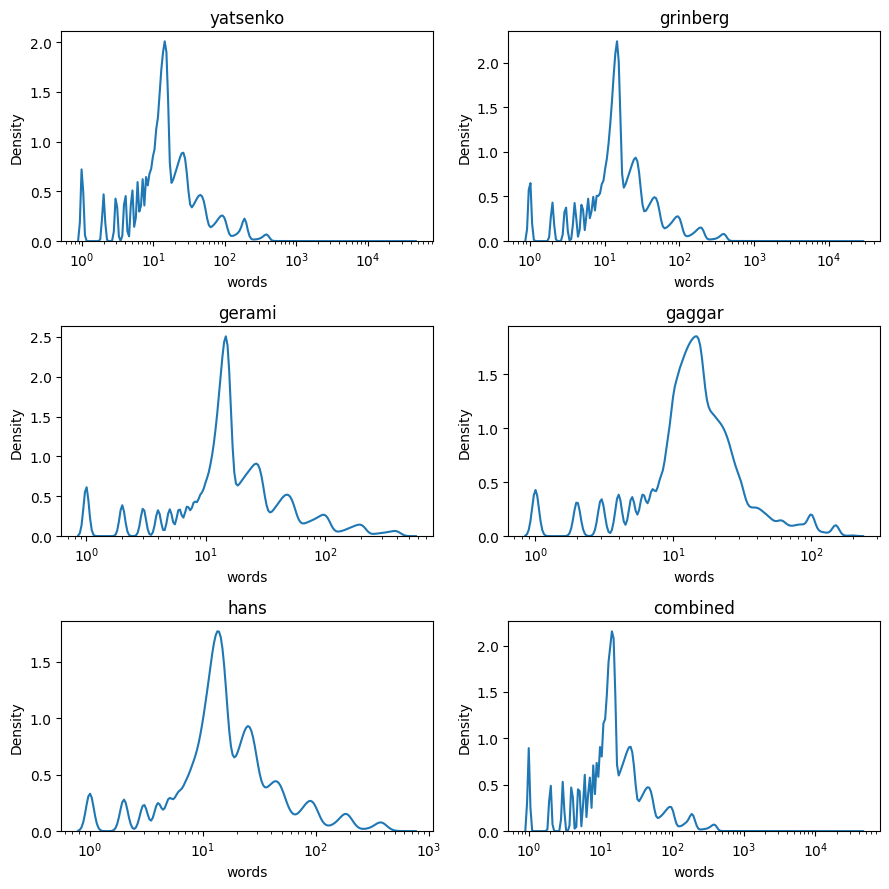

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), squeeze=True)
axs=axs.flatten()

for i, dataset in enumerate(datasets.index):
    plot_data_df=data_df[data_df['source'] == dataset]
    sns.kdeplot(data=plot_data_df, x='words', log_scale=10, legend=False, ax=axs[i])
    axs[i].set_title(dataset)

sns.kdeplot(data=data_df, x='words', log_scale=10, legend=False, ax=axs[-1])
axs[-1].set_title('combined')
plt.tight_layout()
plt.show()

Just for fun, let's take a look at the chunk length distributions for human vs machine text. But before we do - let's provisionally get rid of any single word chunks - we can pretty clearly justify that as a splitting failure, if nothing else. Let's also trim off very long chunks.

In [7]:
working_data_df=data_df[data_df['words'] > 1]
working_data_df=working_data_df[working_data_df['words'] < 1024]

### 3.3. Text length: human vs machine

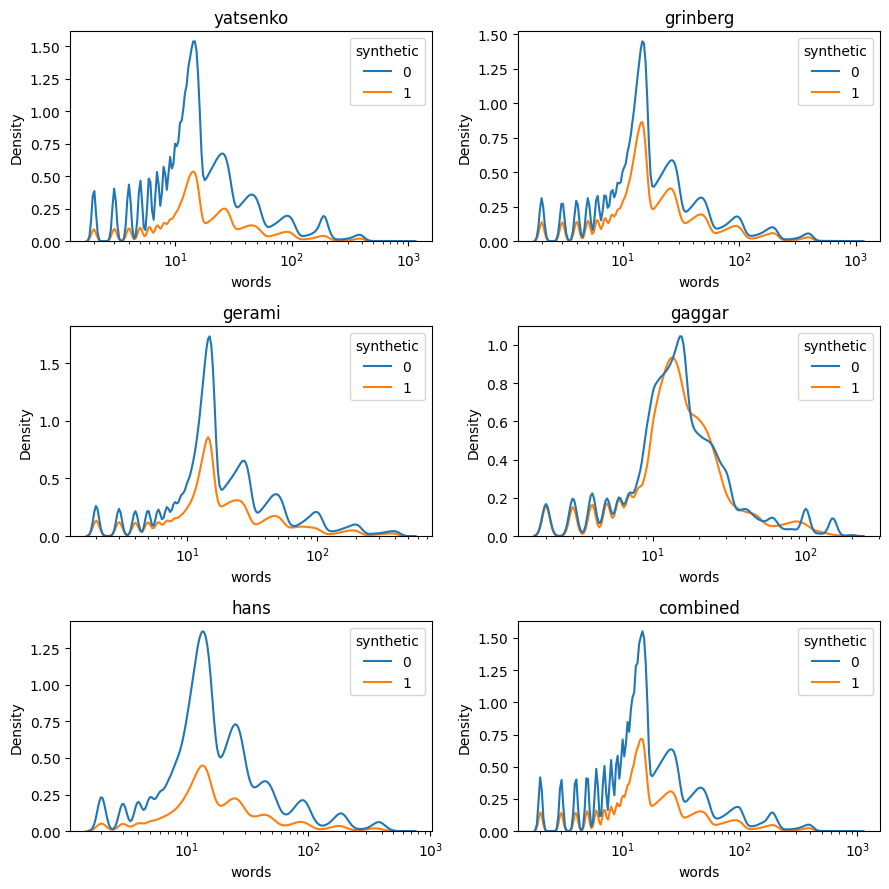

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), squeeze=True)
axs=axs.flatten()

for i, dataset in enumerate(datasets.index):
    plot_data_df=working_data_df[working_data_df['source'] == dataset]
    sns.kdeplot(data=plot_data_df, x='words', hue='synthetic', common_norm=True, log_scale=10, legend=True, ax=axs[i])
    axs[i].set_title(dataset)

sns.kdeplot(data=working_data_df, x='words', hue='synthetic', common_norm=True, log_scale=10, legend=True, ax=axs[-1])
axs[-1].set_title('combined')
plt.tight_layout()
plt.show()

OK - I see differences. Let's try plotting the histogram bin fractions against each other for synthetic and human text.

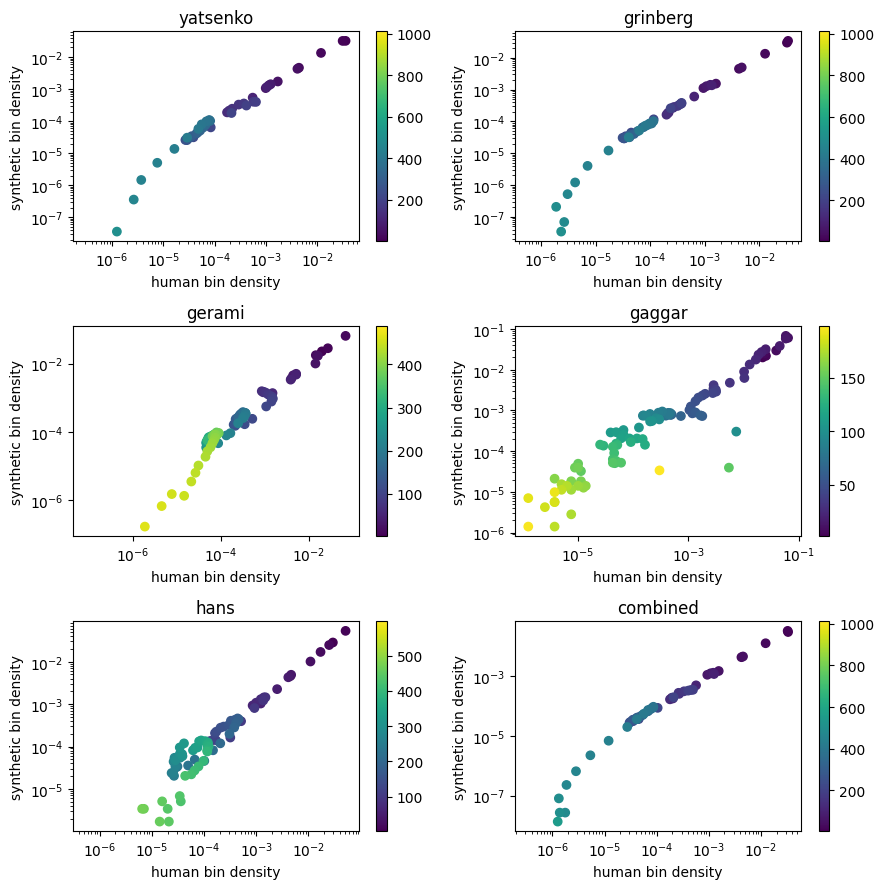

In [9]:
num_bins=100
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 9), squeeze=True)
axs=axs.flatten()

# Loop on the datasets from each source
for i, dataset in enumerate(datasets.index):
    plot_data_df=working_data_df[working_data_df['source'] == dataset]

    # Get bins for human and synthetic data together
    counts, bins=np.histogram(plot_data_df['words'], bins=num_bins)

    # Use the bin edges to get densities for human and synthetic separately
    human_density, human_bins=np.histogram(plot_data_df['words'][plot_data_df['synthetic'] == 0], bins=bins, density=True)
    synthetic_density, synthetic_bins=np.histogram(plot_data_df['words'][plot_data_df['synthetic'] == 1], bins=bins, density=True)

    # Plot the bin densities against each other
    this_plot=axs[i].scatter(x=human_density, y=synthetic_density, c=bins[:-1])
    fig.colorbar(this_plot)
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xlabel('human bin density')
    axs[i].set_ylabel('synthetic bin density')
    axs[i].set_title(dataset)

# Do the same for the complete dataset
counts, bins=np.histogram(working_data_df['words'], bins=num_bins)
human_density, human_bins=np.histogram(working_data_df['words'][working_data_df['synthetic'] == 0], bins=bins, density=True)
synthetic_density, synthetic_bins=np.histogram(working_data_df['words'][working_data_df['synthetic'] == 1], bins=bins, density=True)

last_plot=axs[-1].scatter(x=human_density, y=synthetic_density, c=bins[:-1])
axs[-1].set_yscale('log')
axs[-1].set_xscale('log')
axs[-1].set_xlabel('human bin density')
axs[-1].set_ylabel('synthetic bin density')
axs[-1].set_title('combined')
fig.colorbar(last_plot)
plt.tight_layout()
plt.show()